In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
import scipy as sp
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.gridspec as gridspec
import icf
import timeit
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Plot params
plt.rcParams['font.size'] = 16.0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.0

In [2]:
# Electrostatic PIC code in a 1D cyclic domain

from numpy import arange, concatenate, zeros, linspace, floor, array, pi
from numpy import sin, cos, sqrt, random, histogram, abs, sqrt, max

try:
    import matplotlib.gridspec as gridspec  # For plot layout grid - A grid layout to place subplots within a figure.
    got_gridspec = True
except:
    got_gridspec = False

# Need an FFT routine, either from SciPy or NumPy
try:
    from scipy.fftpack import fft, ifft
except:
    # No SciPy FFT routine. Import NumPy routine instead
    from numpy.fft import fft, ifft

def rk4step(f, y0, dt, args=()):
    """ Takes a single step using RK4 method """
    k1 = f(y0, *args)
    k2 = f(y0 + 0.5*dt*k1, *args)
    k3 = f(y0 + 0.5*dt*k2, *args)
    k4 = f(y0 + dt*k3, *args)

    return y0 + (k1 + 2.*k2 + 2.*k3 + k4)*dt / 6.

def calc_density(position, ncells, L):
    """ Calculate charge density given particle positions
    
    Input
      position  - Array of positions, one for each particle
                  assumed to be between 0 and L
      ncells    - Number of cells
      L         - Length of the domain

    Output
      density   - contains 1 if evenly distributed
    """
    # This is a crude method and could be made more efficient
    
    density = zeros([ncells])
    nparticles = len(position)
    
    dx = L / ncells       # Uniform cell spacing
    for p in position / dx:    # Loop over all the particles, converting position into a cell number
        plower = int(p)        # Cell to the left (rounding down)
        offset = p - plower    # Offset from the left
        density[plower] += 1. - offset # corrects value through offset
        density[(plower + 1) % ncells] += offset # put the rest into the nearby cell
    # nparticles now distributed amongst ncells
    density *= float(ncells) / float(nparticles)  # Make max density equal to 1
    return density

def periodic_interp(y, x):
    """
    Linear interpolation of a periodic array y at index x
    
    Input

    y - Array of values to be interpolated
    x - Index where result required. Can be an array of values
    
    Output
    
    y[x] with non-integer x
    """
    ny = len(y)
    if len(x) > 1:
        y = array(y) # Make sure it's a NumPy array for array indexing
    xl = floor(x).astype(int) # Left index
    dx = x - xl
    xl = ((xl % ny) + ny) % ny  # Ensures between 0 and ny-1 inclusive
    return y[xl]*(1. - dx) + y[(xl+1)%ny]*dx

def fft_integrate(y):
    """ Integrate a periodic function using FFTs
    """
    n = len(y) # Get the length of y
    
    f = fft(y) # Take FFT
    # Result is in standard layout with positive frequencies first then negative
    # n even: [ f(0), f(1), ... f(n/2), f(1-n/2) ... f(-1) ]
    # n odd:  [ f(0), f(1), ... f((n-1)/2), f(-(n-1)/2) ... f(-1) ]
    
    if n % 2 == 0: # If an even number of points
        k = concatenate( (arange(0, n/2+1), arange(1-n/2, 0)) )
    else:
        k = concatenate( (arange(0, (n-1)/2+1), arange( -(n-1)/2, 0)) )
    k = 2.*pi*k/n # Transfer into wave numbers (2pi/n)*k
    
    # Modify frequencies by dividing by ik
    f[1:] /= (1j * k[1:]) 
    f[0] = 0. # Set the arbitrary zero-frequency term to zero
    
    return ifft(f).real # Reverse Fourier Transform
   

def pic(f, ncells, L):
    """ f contains the position and velocity of all particles
    """
    nparticles = len(f) // 2     # Two values for each particle
    pos = f[0:nparticles] # Position of each particle
    vel = f[nparticles:]      # Velocity of each particle

    dx = L / float(ncells)    # Cell spacing

    # Ensure that pos is between 0 and L
    pos = ((pos % L) + L) % L
    
    # Calculate number density, normalised so 1 when uniform
    density = calc_density(pos, ncells, L)
    
    # Subtract ion density to get total charge density
    rho = density - 1.
    
    # Calculate electric field
    E = -fft_integrate(rho)*dx
    
    # Interpolate E field at particle locations
    accel = -periodic_interp(E, pos/dx)

    # Put back into a single array
    return concatenate( (vel, accel) )

####################################################################

def run(pos, vel, L, ncells=None, out=[], output_times=linspace(0,20,100), cfl=0.5):
    
    if ncells == None:
        ncells = int(sqrt(len(pos))) # A sensible default

    dx = L / float(ncells)
    
    f = concatenate( (pos, vel) )   # Starting state
    nparticles = len(pos)
    
    time = 0.0
    for tnext in output_times:
        # Advance to tnext
        stepping = True
        while stepping:
            # Maximum distance a particle can move is one cell
            #cfl is a numerical factor to reduce the maximum possible distance
            dt = cfl * dx / max(abs(vel))
            if time + dt >= tnext:
                # Next time will hit or exceed required output time
                stepping = False
                dt = tnext - time
            #f containts positions and velocities
            f = rk4step(pic, f, dt, args=(ncells, L))
            time += dt
            
        # Extract position and velocities
        pos = ((f[0:nparticles] % L) + L) % L
        vel = f[nparticles:]
        
        # Send to output functions
        for func in out:
            func(pos, vel, ncells, L, time)
        
    return pos, vel

####################################################################
# 
# Output functions and classes
#

class Plot:
    """
    Displays three plots: phase space, charge density, and velocity distribution
    """
    def __init__(self, pos, vel, ncells, L):
        
        d = calc_density(pos, ncells, L)
        vhist, bins  = histogram(vel, int(sqrt(len(vel))))
        vbins = 0.5*(bins[1:]+bins[:-1])
        
        # Plot initial positions
        if got_gridspec:
            self.fig = plt.figure()
            self.gs = gridspec.GridSpec(4, 4)
            ax = self.fig.add_subplot(self.gs[0:3,0:3])
            self.phase_plot = ax.plot(pos, vel, '.')[0]
            ax.set_title("Phase space")
            
            ax = self.fig.add_subplot(self.gs[3,0:3])
            self.density_plot = ax.plot(linspace(0, L, ncells), d)[0]
            
            ax = self.fig.add_subplot(self.gs[0:3,3])
            self.vel_plot = ax.plot(vhist, vbins)[0]
        else:
            self.fig = plt.figure()
            self.phase_plot = plt.plot(pos, vel, '.')[0]
            
            self.fig = plt.figure()
            self.density_plot = plt.plot(linspace(0, L, ncells), d)[0]
            
            self.fig = plt.figure()
            self.vel_plot = plt.plot(vhist, vbins)[0]
        plt.ion()
        plt.show()
        
    def __call__(self, pos, vel, ncells, L, t):
        d = calc_density(pos, ncells, L)
        vhist, bins  = histogram(vel, int(sqrt(len(vel))))
        vbins = 0.5*(bins[1:]+bins[:-1])
        
        self.phase_plot.set_data(pos, vel) # Update the plot
        self.density_plot.set_data(linspace(0, L, ncells), d)
        self.vel_plot.set_data(vhist, vbins)
        plt.draw()
        plt.pause(0.05)
        

class Summary:
    def __init__(self):
        self.t = []
        self.firstharmonic = []
        
    def __call__(self, pos, vel, ncells, L, t):
        # Calculate the charge density
        d = calc_density(pos, ncells, L)
        
        # Amplitude of the first harmonic
        fh = 2.*abs(fft(d)[1]) / float(ncells)
        
        # Time is normalised to plasma freq
        #print("Time: {:5.2f} | FH Amplitude: {:5.3f}".format(t, fh))
        
        self.t.append(t)
        self.firstharmonic.append(fh)

####################################################################
# 
# Functions to create the initial conditions
#

def landau(npart, L, alpha=0.2, rand=True):
    """
    Creates the initial conditions for Landau damping
    
    """
    if rand==False:
        np.random.seed(100)
    # Start with a uniform distribution of positions
    pos = random.uniform(0., L, npart)
    pos0 = pos.copy()
    k = 2.*pi / L
    for i in range(10): # Adjust distribution using Newton iterations
        pos -= ( pos + alpha*sin(k*pos)/k - pos0 ) / ( 1. + alpha*cos(k*pos) )
        
    # Normal velocity distribution
    vel = random.normal(0.0, 1.0, npart)
    
    return pos, vel

def twostream(npart, L, vbeam=2, rand=True):
    if rand==False:
        np.random.seed(1000)
    # Start with a uniform distribution of positions
    pos = random.uniform(0., L, npart)
    # Normal velocity distribution
    vel = random.normal(0.0, 1.0, npart)
    
    np2 = int(npart / 2)
    vel[:np2] += vbeam  # Half the particles moving one way
    vel[np2:] -= vbeam  # and half the other
    
    return pos,vel

####################################################################


In [3]:
def routine(savename, L, nc=20, npart=200, repeats=5):
    
    #Initialise lists
    SNR_list     = np.zeros(repeats)
    freq_list    = np.zeros(repeats)
    errfreq_list = np.zeros(repeats)
    d_list       = np.zeros(repeats)
    errd_list    = np.zeros(repeats)
    simtime      = np.zeros(repeats)
    
    # We want repeats-times looping
    count = 0
    while count < repeats: 
        if __name__ == "__main__":
            # Generate initial condition
            npart = int(npart)
            if False:
                # 2-stream instability
                L = L#100
                ncells = nc#2.e5 #20
                pos, vel = twostream(npart, L, 3., rand=True) # Might require more npart than Landau!
            else:
                # Landau damping
                L = L#4.*pi
                ncells = nc #2.e5 #20
                # Get initial values
                pos, vel = landau(npart, L, rand=True)

            # Create some output classes
            #p = Plot(pos, vel, ncells, L) # This displays an animated figure - Slow!
            s = Summary()                 # Calculates, stores and prints summary info

            diagnostics_to_run = [s]   # Remove p to get much faster code!

            # Run the simulation
            starttime = timeit.default_timer()
            pos, vel = run(pos, vel, L, ncells, 
                           out = diagnostics_to_run,        # These are called each output step
                           output_times=linspace(0.,20,50)) # The times to output
            stoptime = timeit.default_timer()
            simtime[count] = stoptime-starttime
        
        #Get data from run and save it as numpy array for further analysis
        time = np.array(s.t)
        amp = np.array(s.firstharmonic)

        #Find index of peaks
        peaks = sp.signal.find_peaks(amp)[0]

        #Find where noisy region starts
        #Def: First peak larger than previous one
        prev_index = peaks[0]
        for arg, peak in enumerate(peaks):
            current_index = peak
            if amp[prev_index] > amp[current_index]:
                prev_index = current_index
                #Continuing these values
                arg_noisy_peak = arg
                noisy_peak = current_index
            if amp[prev_index] < amp[current_index]:
                noisy_peak = current_index
                arg_noisy_peak = arg
                break;

        #if we have 3 (or less) peaks within the signal area, we just have 1 freq and therefore no error to it! 
        #(the last peak does not count, since its the noise)
        if arg_noisy_peak <=3:
            continue;
            
        #Find the average of the noise after the cut-off
        noise_level=np.mean(amp[peaks[arg_noisy_peak:]])
        
        # Save usefull data with a least 4 peaks
        savedata = np.array([time, amp])
        filename = savename+"_"+"("+str(round(L, 2))+"-"+str(nc)+"-"+str(npart)+")_"+str(count)+".txt"
        np.savetxt(fname= filename, 
                   X=savedata,  delimiter=' ', newline='\n', header=' run-time , first harmonics amplitde')

        
        #############################################################
        #############################################################
        #Cut off index, where noise start
        cut_off = noisy_peak

        #Separate code to usefull data and noisy data
        time = time[:cut_off]
        amp = amp[:cut_off]

        #Seperate peaks until the cut-off
        peaks = peaks[:arg_noisy_peak]

        #Interpolate freq between the clear peaks
        # Time-Differenz between two peaks is 2-times the period
        # Inverse of this leads to freq
        freqs = np.array([])
        prev_peak = peaks[0]
        for peak in peaks:
            if len(peaks) == 1:
                print("Not enough data!")
                break;
            if len(peaks)>1 and prev_peak != peak:
                dt = 2*(time[peak]-time[prev_peak])
                freqs = np.append(freqs, 1/dt)
            prev_peak = peak

        
        #Define hull function for the fit -> finding decay rate!
        def hull(t, *params):
            A_0 = params[0]
            d = params[1]
            return A_0*np.exp(-d*t)
        
        x = time[peaks]
        y = amp[peaks]
        #Guess the fit-parameters and narrow the range for physical results
        guess= np.array([0.01, 0.153])
        ranges=([0.001, 0.153-0.1],[1,0.153+0.1])
        popt, pcov = curve_fit(hull, x, y, guess, bounds=ranges)

        # Grab a copy of the best fit line
        yfit = hull(x, *popt)
        
        # Get decay ray fit-results and its error
        d_list[count] = popt[1]
        errd_list[count] = np.sqrt(pcov[1][1])
        
        # Signal to Noise ratio - defined as the highest peak against the average of all peaks WITHIN the noisy region
        SNR = np.max(amp[peaks])/noise_level
        SNR_list[count] = SNR
        
        # Omega as the angular freq - note: omega = 2*pi*f !
        mean_omega = np.mean(freqs)*2*np.pi
        sigma_omega = np.std(freqs, ddof=1)*2*np.pi
        freq_list[count] = mean_omega
        errfreq_list[count] =sigma_omega
        
        #Next cycle for looping
        count+=1
        
    return SNR_list, d_list, errd_list, freq_list, errfreq_list, simtime

In [4]:
#Initialise global data for change in nc, npart , L - 
# Signal to noise ratio SNR, simulation time tau, angular freq omega, decay rate d
# Data matrix for 3 parameters and for each 4 different values 
G_SNR         = np.zeros((3,4))
Gerr_SNR      = np.zeros((3,4))
G_simtime     = np.zeros((3,4))
Gerr_simtime  = np.zeros((3,4))
G_omega       = np.zeros((3,4))
Gerr_omega    = np.zeros((3,4))
G_d           = np.zeros((3,4))
Gerr_d        = np.zeros((3,4))

#Number of cells 
nc_vals = []
for power in range(0, 3+1):
    nc_vals.append(2*10**power)
#Number of particles
npart_vals = []
for power in range(1, 4+1):
    npart_vals.append(2*10**power)
#Length of box
L_vals = [1,2,3,4]
L_vals = [i * 2*np.pi for i in L_vals]

In [11]:
#Start here with the complete routine
completestart = timeit.default_timer()
for index, L in enumerate(L_vals):
    parameter = 0
    SNR_list, d_list, errd_list, freq_list, errfreq_list , simtime= routine(savename="run",L=L, nc=200, npart=200, repeats=5)
    G_SNR[parameter,index]        = np.mean(SNR_list)
    Gerr_SNR[parameter,index]     = np.std(SNR_list, ddof=1)
    G_simtime[parameter,index]    = np.mean(simtime)
    Gerr_simtime[parameter,index] = np.std(simtime, ddof=1)
    G_omega[parameter,index]      = np.mean(freq_list)
    Gerr_omega[parameter,index]   = np.std(freq_list, ddof=1)
    G_d[parameter,index]          = np.mean(d_list)
    Gerr_d[parameter,index]       = np.std(d_list, ddof=1)

In [12]:
# THIS simulation takes way longer than the other two
for index, nc in enumerate(nc_vals):
    parameter = 1
    SNR_list, d_list, errd_list, freq_list, errfreq_list , simtime= routine(savename="run",L=4*np.pi, nc=nc, npart=200, repeats=5)
    G_SNR[parameter,index]        = np.mean(SNR_list)
    Gerr_SNR[parameter,index]     = np.std(SNR_list, ddof=1)
    G_simtime[parameter,index]    = np.mean(simtime)
    Gerr_simtime[parameter,index] = np.std(simtime, ddof=1)
    G_omega[parameter,index]      = np.mean(freq_list)
    Gerr_omega[parameter,index]   = np.std(freq_list, ddof=1)
    G_d[parameter,index]          = np.mean(d_list)
    Gerr_d[parameter,index]       = np.std(d_list, ddof=1)

In [13]:
for index, npart in enumerate(npart_vals):
    parameter = 2
    SNR_list, d_list, errd_list, freq_list, errfreq_list , simtime= routine(savename="run",L=4*np.pi, nc=200, npart=npart, repeats=5)
    G_SNR[parameter,index]        = np.mean(SNR_list)
    Gerr_SNR[parameter,index]     = np.std(SNR_list, ddof=1)
    G_simtime[parameter,index]    = np.mean(simtime)
    Gerr_simtime[parameter,index] = np.std(simtime, ddof=1)
    G_omega[parameter,index]      = np.mean(freq_list)
    Gerr_omega[parameter,index]   = np.std(freq_list, ddof=1)
    G_d[parameter,index]          = np.mean(d_list)
    Gerr_d[parameter,index]       = np.std(d_list, ddof=1)
completeend = timeit.default_timer()

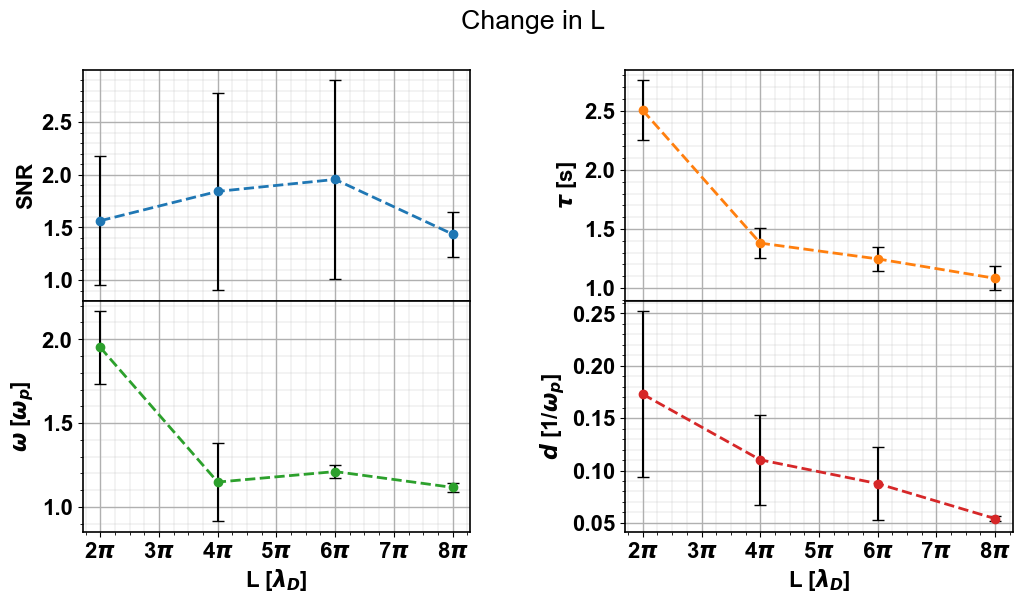

In [35]:
# Plot and show results for change in L
x = L_vals
parameter = 0
parametername="L"

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0.4)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col')
fig.suptitle('Change in '+parametername)

ax1.errorbar(x, G_SNR[parameter,:], yerr=Gerr_SNR[parameter,:], marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax1.set_ylabel("SNR")
ax1.grid(which = "major", linewidth = 1)
ax1.grid(which = "minor", linewidth = 0.2)
ax1.minorticks_on()

ax2.errorbar(x, G_simtime[parameter,:], yerr=Gerr_simtime[parameter,:],color='tab:orange', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax2.set_ylabel(r"$\tau$ [s]")
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()

ax3.errorbar(x, G_omega[parameter,:], yerr=Gerr_omega[parameter,:],color='tab:green', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax3.set_ylabel(r"$\omega$ [$\omega_p$]")
ax3.set_xlabel(parametername+r" [$\lambda_D$]")
ax3.grid(which = "major", linewidth = 1)
ax3.grid(which = "minor", linewidth = 0.2)
ax3.minorticks_on()
ax3.set_xticks(np.arange(2*np.pi, 8*np.pi+0.1, 4*np.pi))
ax3.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax3.xaxis.set_major_locator(MultipleLocator(base=np.pi))

ax4.errorbar(x, G_d[parameter,:], yerr=Gerr_d[parameter,:],color='tab:red', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax4.set_ylabel(r"$d$ [1/$\omega_p$]")
ax4.set_xlabel(parametername+r" [$\lambda_D$]")
ax4.grid(which = "major", linewidth = 1)
ax4.grid(which = "minor", linewidth = 0.2)
ax4.minorticks_on()
ax4.set_xticks(np.arange(2*np.pi, 8*np.pi+0.1, 4*np.pi))
ax4.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax4.xaxis.set_major_locator(MultipleLocator(base=np.pi))
plt.savefig("changeL")

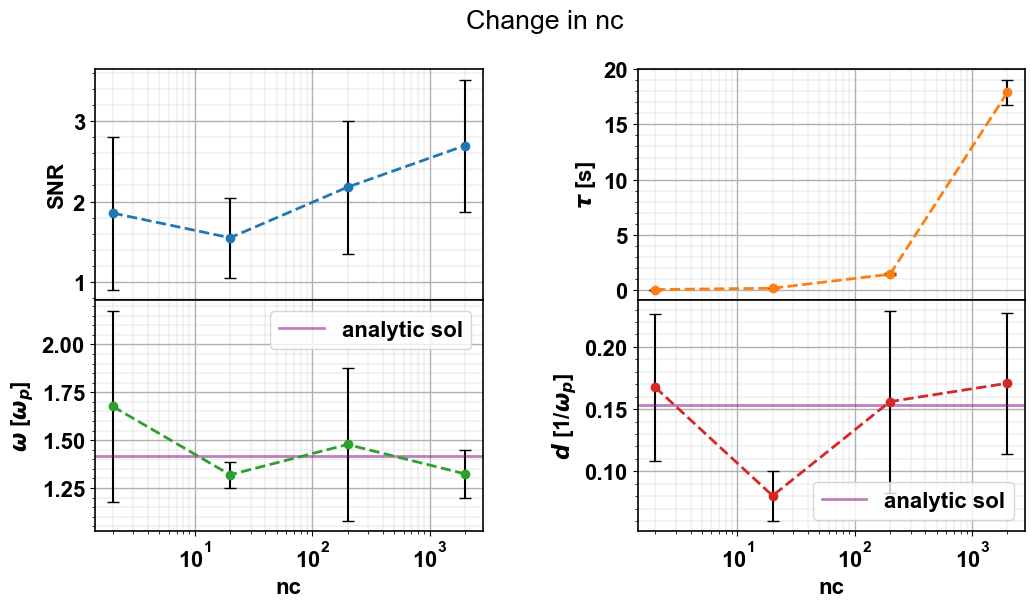

In [29]:
# Plot and show results for change in nc
x = nc_vals
parameter = 1
parametername="nc"

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0.4)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col')
fig.suptitle('Change in '+parametername)

ax1.errorbar(x, G_SNR[parameter,:], yerr=Gerr_SNR[parameter,:], marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax1.set_ylabel("SNR")
ax1.grid(which = "major", linewidth = 1)
ax1.grid(which = "minor", linewidth = 0.2)
ax1.minorticks_on()
ax1.set_xscale('log')

ax2.errorbar(x, G_simtime[parameter,:], yerr=Gerr_simtime[parameter,:],color='tab:orange', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax2.set_ylabel(r"$\tau$ [s]")
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
ax2.set_xscale('log')

ax3.errorbar(x, G_omega[parameter,:], yerr=Gerr_omega[parameter,:],color='tab:green', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax3.set_ylabel(r"$\omega$ [$\omega_p$]")
ax3.set_xlabel(parametername)
ax3.axhline(y=1.416, color="purple", label="analytic sol", alpha=0.5)
ax3.legend(loc="upper right")
ax3.grid(which = "major", linewidth = 1)
ax3.grid(which = "minor", linewidth = 0.2)
ax3.minorticks_on()
ax3.set_xscale('log')

ax4.errorbar(x, G_d[parameter,:], yerr=Gerr_d[parameter,:],color='tab:red', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax4.set_ylabel(r"$d$ [1/$\omega_p$]")
ax4.set_xlabel(parametername)
ax4.axhline(y=0.153, color="purple", label="analytic sol", alpha=0.5)
ax4.legend(loc="lower right")
ax4.grid(which = "major", linewidth = 1)
ax4.grid(which = "minor", linewidth = 0.2)
ax4.minorticks_on()
ax4.set_xscale('log')
plt.savefig("changenc")

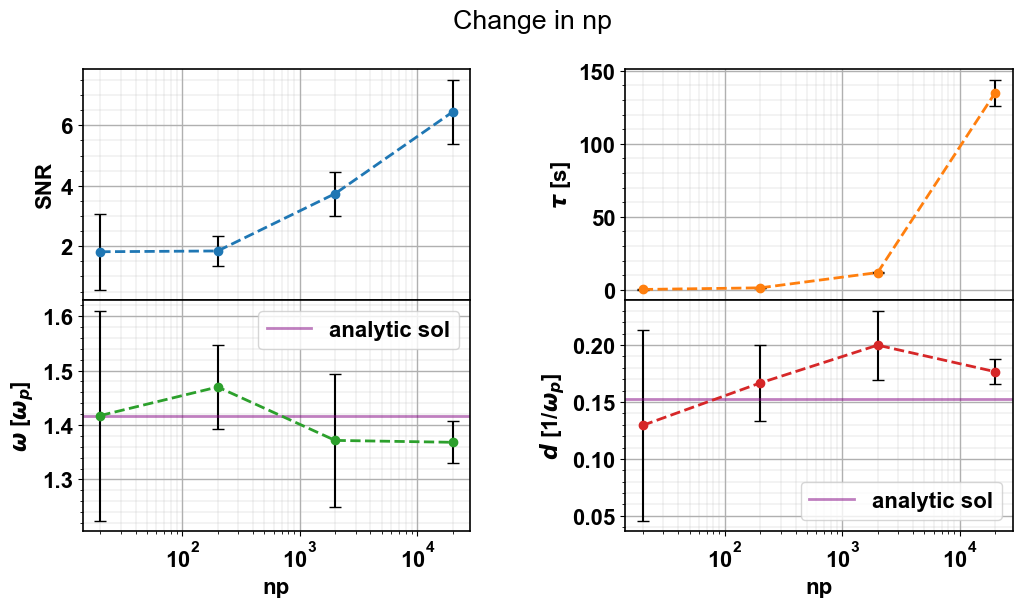

In [30]:
# Plot and show results for change in npart
x = npart_vals
parameter = 2
parametername="np"

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0.4)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col')
fig.suptitle('Change in '+parametername)

ax1.errorbar(x, G_SNR[parameter,:], yerr=Gerr_SNR[parameter,:], marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax1.set_ylabel("SNR")
ax1.grid(which = "major", linewidth = 1)
ax1.grid(which = "minor", linewidth = 0.2)
ax1.minorticks_on()
ax1.set_xscale('log')

ax2.errorbar(x, G_simtime[parameter,:], yerr=Gerr_simtime[parameter,:],color='tab:orange', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax2.set_ylabel(r"$\tau$ [s]")
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
ax2.set_xscale('log')

ax3.errorbar(x, G_omega[parameter,:], yerr=Gerr_omega[parameter,:],color='tab:green', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax3.set_ylabel(r"$\omega$ [$\omega_p$]")
ax3.set_xlabel(parametername)
ax3.axhline(y=1.416, color="purple", label="analytic sol", alpha=0.5)
ax3.legend(loc="upper right")
ax3.grid(which = "major", linewidth = 1)
ax3.grid(which = "minor", linewidth = 0.2)
ax3.minorticks_on()
ax3.set_xscale('log')

ax4.errorbar(x, G_d[parameter,:], yerr=Gerr_d[parameter,:],color='tab:red', marker="o", linestyle="--", ecolor="black", elinewidth=1.5,capsize=4)
ax4.set_ylabel(r"$d$ [1/$\omega_p$]")
ax4.set_xlabel(parametername)
ax4.axhline(y=0.153, color="purple", label="analytic sol", alpha=0.5)
ax4.legend(loc="lower right")
ax4.grid(which = "major", linewidth = 1)
ax4.grid(which = "minor", linewidth = 0.2)
ax4.minorticks_on()
ax4.set_xscale('log')
plt.savefig("changenp")

In [18]:
(completeend-completestart)/60

25.126363076666774

In [ ]:
# Excluded code

# Summary stores an array of the first-harmonic amplitude
# Make a semilog plot to see exponential damping
plt.figure()
plt.plot(s.t, s.firstharmonic)
plt.title(r"$n_c$ = {}".format(ncells))
plt.xlabel("Time [Normalised]")
plt.ylabel("First harmonic amplitude [Normalised]")
plt.yscale('log')

plt.ioff() # This so that the windows stay open
plt.show()

#Save data
time = s.t
amp = s.firstharmonic
savedata = np.array([time, amp])

np.savetxt(fname="rawdata_{}.txt".format(count), X=savedata,  
           delimiter=' ', newline='\n', header=' run-time , first harmonics amplitde')


#Load data
data = np.loadtxt("rawdata_{}.txt".format(count))

#Plot peaks
plt.figure(figsize=(9,6))
plt.plot(time, amp, label="data")
for peak in peaks:
    plt.plot(time[peak], amp[peak], color="red", marker="x", markersize=10, linewidth=10)

plt.axvline(time[noisy_peak], color="black", label="noise starts")
plt.axhline(noise_level, color="orange", label="avg noise level", linestyle='--')
plt.axvspan(xmin=0, xmax=time[noisy_peak], color="green", alpha=0.2, label="clear area") 
plt.title(r"Clean and noisy region sorting")
plt.xlabel("time [norm]")
plt.ylabel("FH amplitude [norm]")
plt.xlim(min(time), max(time))
plt.legend(loc="upper right")
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()
plt.tight_layout()
plt.show()

 # Plot whole data
plt.rcParams['font.size'] = 18.0
fig, axarray = plt.subplots(2, 1, figsize=(9,6), sharex=True, gridspec_kw={'height_ratios': [5, 2]})
plt.suptitle("Hull function fit around Landau damping")

axarray[0].errorbar(x, y, yerr=np.zeros(len(x)), color='tab:blue', fmt='.', marker='o', markeredgecolor='tab:blue', label="data", markersize=7)
axarray[0].errorbar(x, y, yerr=np.zeros(len(x)), color='tab:blue', fmt='.', linestyle="--", markeredgecolor='tab:blue', markersize=7)
axarray[0].set_ylabel('FH amplitude [norm]')
axarray[0].plot(x, yfit, color='tab:red', label="hull fit")
axarray[0].legend()

#Residual errors
sigmaRes = np.zeros(len(x))

# Zunächst plotten wir eine gestrichelte Nulllinie, dann den eigentlichen Residuenplot:
axarray[1].axhline(y=0., color='black', linestyle='--')
axarray[1].errorbar(x, y-yfit, yerr=sigmaRes, color='tab:blue', fmt='.', marker='o', markersize=7)
axarray[1].set_xlabel('time [norm]')
axarray[1].set_ylabel('$y_{data} - y_{fit}$')

# Wir sorgen dafür, dass die y-Achse beim Residuenplot symmetrisch um die Nulllinie ist:
ymax = max([abs(x) for x in axarray[1].get_ylim()])
axarray[1].set_ylim(-ymax, ymax)

#Finales Layout:
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

parametername = ["A_0", "d"]
print("------- Hull fit parameter: -------")
for i in range(len(popt)):
    print ("Parameter {:<5} : {:8.4f}   +/- {:8.4f}".format(parametername[i], popt[i], np.sqrt(pcov[i][i])))
print("Fit quality | R^2 = ", icf.r_squared(y, yfit))

#runname = savename+"_"+"("+str(round(L, 2))+"-"+str(nc)+"-"+str(npart)+").txt"